# **Предсказание цены (close) акции GAZP на cледующую минуту**

## 1. Импортируем библиотеки, загружаем данные, проводим первичный анализ

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

In [2]:
# подключение гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Экспортируем данные ГАЗПРОМ ао с площадки [Finam](https://www.finam.ru/quote/moex/gazp/export/) в csv-файл со следующими параметрами:
  * периодичность - минута;
  * формат даты - ггггммдд;
  * формат времени - чч:мм:сс;
  * интервал -  с 08.10.2024 по 08.01.2025;
  * выдавать время - московское (окончания свечи);
  * разделитель полей - ",".
#### Загрузим csv-файл на гугл диск.

In [3]:
bc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pet project/Skillbox/GAZP_241008_250108.csv")
bc

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,1,20241008,10:01:00,133.18,133.41,133.14,133.24,171130
1,GAZP,1,20241008,10:02:00,133.20,133.37,133.18,133.34,138770
2,GAZP,1,20241008,10:03:00,133.34,133.35,133.20,133.23,121920
3,GAZP,1,20241008,10:04:00,133.20,133.24,133.01,133.09,101930
4,GAZP,1,20241008,10:05:00,133.10,133.20,132.90,133.15,263540
...,...,...,...,...,...,...,...,...,...
51481,GAZP,1,20250108,19:23:00,129.53,129.53,129.51,129.53,1260
51482,GAZP,1,20250108,19:24:00,129.53,129.89,129.50,129.68,270440
51483,GAZP,1,20250108,19:25:00,129.68,129.72,129.68,129.71,4490
51484,GAZP,1,20250108,19:26:00,129.72,129.75,129.65,129.65,23160


In [4]:
# Переименовываем столбцы
bc = bc.rename(columns={'<TICKER>': 'ticker',
                        '<PER>': 'per',
                        '<DATE>': 'date',
                        '<TIME>': 'time',
                        '<OPEN>': 'open',
                        '<HIGH>': 'high',
                        '<LOW>': 'low',
                        '<CLOSE>': 'close',
                        '<VOL>': 'vol'
                        })
bc.head()

,ticker,per,date,time,open,high,low,close,vol
0,GAZP,1,20241008,10:01:00,133.18,133.41,133.14,133.24,171130
1,GAZP,1,20241008,10:02:00,133.20,133.37,133.18,133.34,138770
2,GAZP,1,20241008,10:03:00,133.34,133.35,133.20,133.23,121920
3,GAZP,1,20241008,10:04:00,133.20,133.24,133.01,133.09,101930
4,GAZP,1,20241008,10:05:00,133.10,133.20,132.90,133.15,263540


In [5]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51486 entries, 0 to 51485
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  51486 non-null  object 
 1   per     51486 non-null  int64  
 2   date    51486 non-null  int64  
 3   time    51486 non-null  object 
 4   open    51486 non-null  float64
 5   high    51486 non-null  float64
 6   low     51486 non-null  float64
 7   close   51486 non-null  float64
 8   vol     51486 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.5+ MB


In [6]:
# переводим столбец "date" к строковому типу
bc.date = bc.date.astype('str')
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51486 entries, 0 to 51485
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  51486 non-null  object 
 1   per     51486 non-null  int64  
 2   date    51486 non-null  object 
 3   time    51486 non-null  object 
 4   open    51486 non-null  float64
 5   high    51486 non-null  float64
 6   low     51486 non-null  float64
 7   close   51486 non-null  float64
 8   vol     51486 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 3.5+ MB


In [7]:
# создаем столбец "date_time" из столбца даты и времени
bc['date_time'] = bc.date + bc.time

In [8]:
bc.head()

,ticker,per,date,time,open,high,low,close,vol,date_time
0,GAZP,1,20241008,10:01:00,133.18,133.41,133.14,133.24,171130,2024100810:01:00
1,GAZP,1,20241008,10:02:00,133.20,133.37,133.18,133.34,138770,2024100810:02:00
2,GAZP,1,20241008,10:03:00,133.34,133.35,133.20,133.23,121920,2024100810:03:00
3,GAZP,1,20241008,10:04:00,133.20,133.24,133.01,133.09,101930,2024100810:04:00
4,GAZP,1,20241008,10:05:00,133.10,133.20,132.90,133.15,263540,2024100810:05:00


In [9]:
# переводим столбец "date_time" к формату date_time
bc.date_time = pd.to_datetime(bc.date_time, format='%Y%m%d%H:%M:%S')

In [10]:
bc.head()

,ticker,per,date,time,open,high,low,close,vol,date_time
0,GAZP,1,20241008,10:01:00,133.18,133.41,133.14,133.24,171130,2024-10-08 10:01:00
1,GAZP,1,20241008,10:02:00,133.20,133.37,133.18,133.34,138770,2024-10-08 10:02:00
2,GAZP,1,20241008,10:03:00,133.34,133.35,133.20,133.23,121920,2024-10-08 10:03:00
3,GAZP,1,20241008,10:04:00,133.20,133.24,133.01,133.09,101930,2024-10-08 10:04:00
4,GAZP,1,20241008,10:05:00,133.10,133.20,132.90,133.15,263540,2024-10-08 10:05:00


In [11]:
# удаляем не информативные столбцы
bc.drop(['date', 'time', 'ticker', 'per'], axis=1, inplace=True)

In [12]:
bc.head()

,open,high,low,close,vol,date_time
0,133.18,133.41,133.14,133.24,171130,2024-10-08 10:01:00
1,133.20,133.37,133.18,133.34,138770,2024-10-08 10:02:00
2,133.34,133.35,133.20,133.23,121920,2024-10-08 10:03:00
3,133.20,133.24,133.01,133.09,101930,2024-10-08 10:04:00
4,133.10,133.20,132.90,133.15,263540,2024-10-08 10:05:00


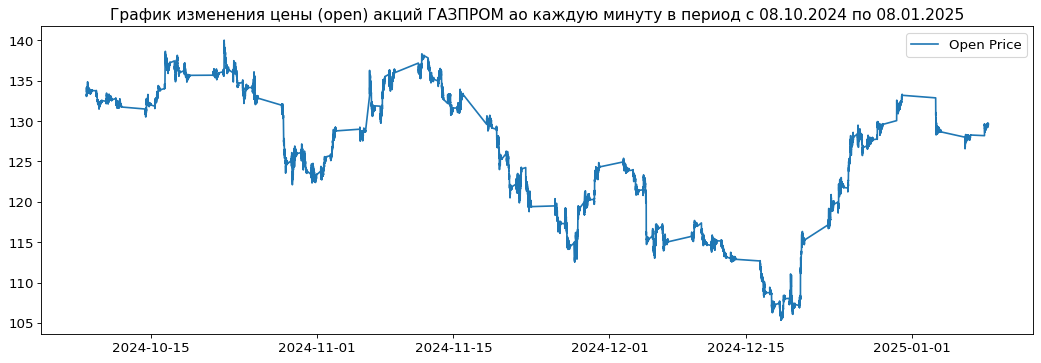

In [13]:
# Draw Plot for Each Category
plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(bc.date_time, bc.open, label="Open Price")

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("График изменения цены (open) акций ГАЗПРОМ ао каждую минуту в период с 08.10.2024 по 08.01.2025", fontsize=14)
plt.legend(fontsize=12)
plt.show()

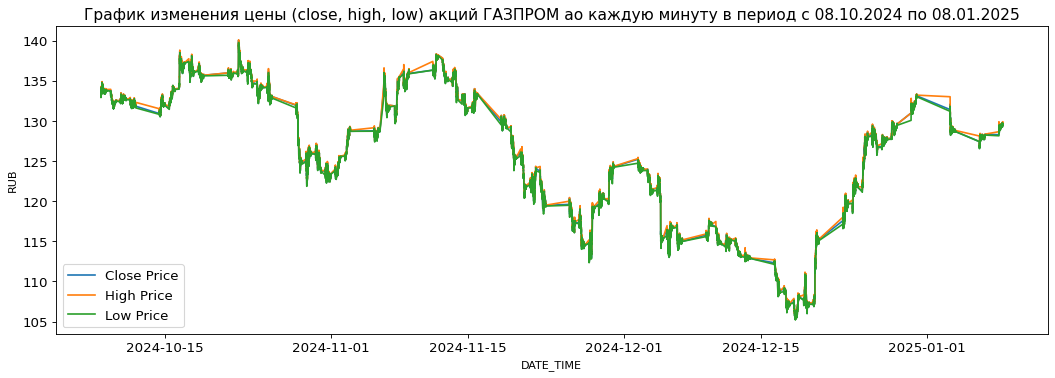

In [14]:
# Draw Plot for Each Category
plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(bc.date_time, bc.close, label="Close Price")
plt.plot(bc.date_time, bc.high, label="High Price")
plt.plot(bc.date_time, bc.low, label="Low Price")

# Decorations
plt.gca().set(xlabel='DATE_TIME', ylabel='RUB')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("График изменения цены (close, high, low) акций ГАЗПРОМ ао каждую минуту в период с 08.10.2024 по 08.01.2025", fontsize=14)
plt.legend(fontsize=12)
plt.show()

## 2. Подготовка данных

In [15]:
# сдвигаем столбец "close", так чтобы в столбце "target" была цена (close) следующей минуты
bc["target"] = bc.close.shift(-1)
bc.head()

,open,high,low,close,vol,date_time,target
0,133.18,133.41,133.14,133.24,171130,2024-10-08 10:01:00,133.34
1,133.20,133.37,133.18,133.34,138770,2024-10-08 10:02:00,133.23
2,133.34,133.35,133.20,133.23,121920,2024-10-08 10:03:00,133.09
3,133.20,133.24,133.01,133.09,101930,2024-10-08 10:04:00,133.15
4,133.10,133.20,132.90,133.15,263540,2024-10-08 10:05:00,133.20


In [16]:
# удаляем пропуски
bc = bc.dropna()
# и столбец со временем, так как он может плохо повлиять на предсказания
bc.drop("date_time", axis=1, inplace=True)

<ipython-input-16-6482bc7c951b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc.drop("date_time", axis=1, inplace=True)


In [17]:
# сформируем features & target
X = bc.drop("target", axis=1)
y = bc.target

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

## 3. Обучение

In [19]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_pred

array([124.8942, 124.2572, 135.5594, ..., 125.1532, 127.3307, 116.653 ])

## 4. Оценка качества модели

In [22]:
mean_absolute_error(y_test, y_pred)

0.06923620689336245

In [23]:
r2_score(y_test, y_pred)

0.9998337870549729

In [24]:
print(f'MAE = {round(mean_absolute_error(y_test, y_pred), 0)}.')
print(f'R^2 = {round(r2_score(y_test, y_pred), 0)}.')
print(f'MAX_error = {round(max_error(y_test, y_pred), 0)}.')
print(f'В среднем модель ошибается в своем предсказании на {round(mean_absolute_error(y_pred, y_test), 2)} руб.')

MAE = 0.0.
R^2 = 1.0.
MAX_error = 3.0.
В среднем модель ошибается в своем предсказании на 0.07 руб.


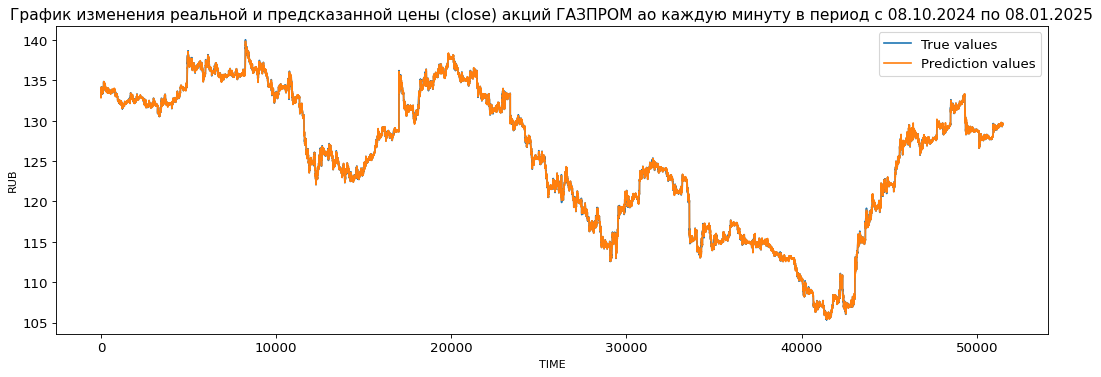

In [25]:
# Draw Plot for Each Category
plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(y, label="True values")
plt.plot(model.predict(X), label="Prediction values")

# Decorations
plt.gca().set(xlabel='TIME', ylabel='RUB')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("График изменения реальной и предсказанной цены (close) акций ГАЗПРОМ ао каждую минуту в период с 08.10.2024 по 08.01.2025", fontsize=14)
plt.legend(fontsize=12)
plt.show()

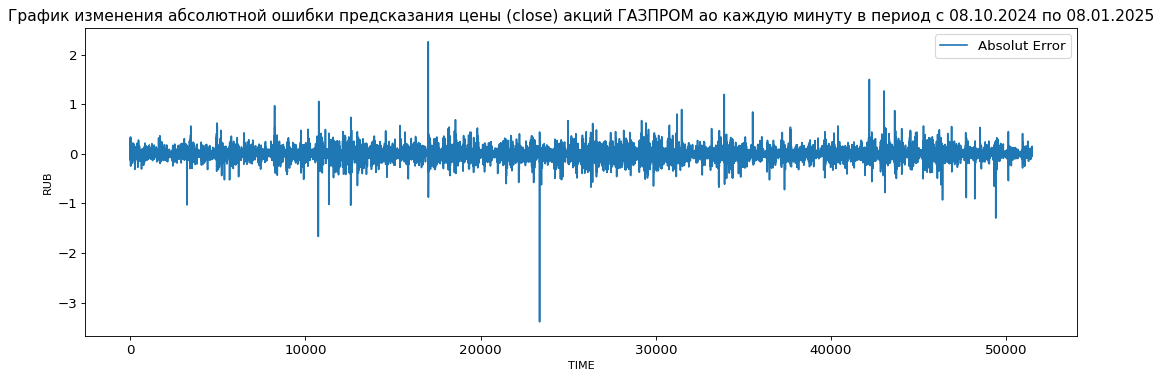

In [26]:
# Draw Plot for Each Category
plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')

ful_prediction = model.predict(X)
error = y - ful_prediction
plt.plot(error, label="Absolut Error")

# Decorations
plt.gca().set(xlabel='TIME', ylabel='RUB')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("График изменения абсолютной ошибки предсказания цены (close) акций ГАЗПРОМ ао каждую минуту в период с 08.10.2024 по 08.01.2025", fontsize=14)
plt.legend(fontsize=12)
plt.show()

## 5. Оценка значимости features for target

In [27]:
round(pd.DataFrame(data=[model.feature_importances_], columns=X.columns).T, 2)

,0
open,0.00
high,0.03
low,0.02
close,0.94
vol,0.00


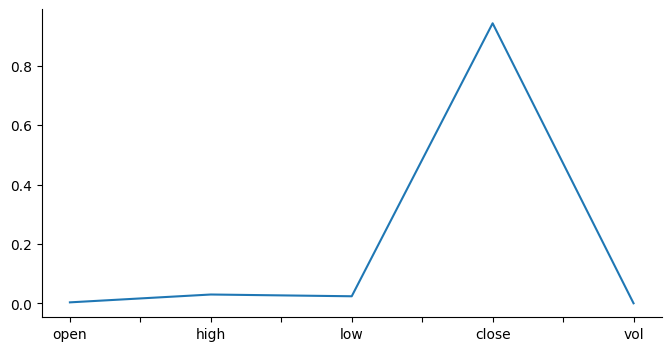

In [28]:
pd.DataFrame(data=[model.feature_importances_], columns=X.columns).T[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

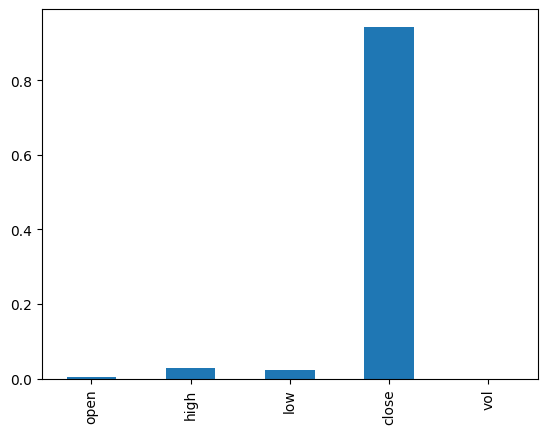

In [29]:
pd.DataFrame(data=[model.feature_importances_], columns=X.columns).T[0].plot(kind='bar', title=0)

## **Вывод**
  * *В среднем модель ошибается в своем предсказании на 0.07 руб.*
  * *Максимальная ошибка - 3.0 руб.*
  * *Наиболее значимым признаком является "close" за предыдущий период.*